<a href="https://colab.research.google.com/github/oqba06878/GPU-Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1> GPU Project:  Effecient Parallelization of Edmond's Karp Algorithm </h1>**

<h3><b>Authors:</b> Maha Usmani, Shehryar Amin, Oqba Jawed</h3>

**<h2> CPU Implementation </h2>**

adjacency matrix for graph 

In [ ]:
%%writefile edmondsKarp.c
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>

#define MAX_NODES 1000

int min(int a, int b) {
    if (a < b) {
        return a;
    } else {
        return b;
    }
}

int bfs(int graph[MAX_NODES][MAX_NODES], int source, int sink, int parent[MAX_NODES], int nodes) {
    int visited[MAX_NODES] = {0}; //visited nodes
    int queue[MAX_NODES]; //bfs queue
    int front = 0;
    int rear = 0;
    queue[rear++] = source;
    visited[source] = 1;
    parent[source] = -1; //not sure

    // loop until the queue is empty or we have found a path from source to sink
    while (front != rear) {
        int u = queue[front++];
        // check all neighbors of u
        for (int v = 0; v < nodes; v++) {
            //printf("why not coming here!!!!");
            if (visited[v] == 0 && graph[u][v] > 0) {
                parent[v] = u;
                visited[v] = 1;
                queue[rear++] = v;
            }
        }
    }

    // if we found a path from source to sink, return 1
    return visited[sink];
}

int edmonds_karp(int graph[MAX_NODES][MAX_NODES], int source, int sink, int nodes) {
    int parent[MAX_NODES]; // parent[i] stores the parent node of node i in the augmented path
    int max_flow = 0;

    // loop until no path from source to sink
    while (bfs(graph, source, sink, parent, nodes)) {
        // find maximum flow that can be sent along the path
        int path_flow = INT_MAX;
        for (int v = sink; v != source; v = parent[v]) {
            int u = parent[v];
            path_flow = min(path_flow, graph[u][v]);
        }

        // update the residual capacities of the edges and the maximum flow
        for (int v = sink; v != source; v = parent[v]) {
            //printf("%d", v);
            int u = parent[v];
            graph[u][v] -= path_flow;
            graph[v][u] += path_flow;
        }
        max_flow = max_flow + path_flow;
    }

    return max_flow;
}

int main() {
    int graph[MAX_NODES][MAX_NODES] = {0};
    int nodes, edges, u, v, w, source, sink;

    printf("Enter the number of nodes, edges, source, and sink: ");
    scanf("%d %d %d %d", &nodes, &edges, &source, &sink);

    printf("Enter the edges with their weights:\n");
    for (int i = 0; i < edges; i++) {
        scanf("%d %d %d", &u, &v, &w);
        graph[u][v] = w;
    }

    printf("hello i dont know why not getting here :C\n");
    
    int max_flow = edmonds_karp(graph, source, sink, nodes);
    printf("Me done!!\n");
    printf("Maximum flow: %d\n", max_flow);
    return 0;
}

Overwriting edmondsKarp.c


In [ ]:
!gcc edmondsKarp.c -lm
!./a.out

Enter the number of nodes, edges, source, and sink: 6 9 0 5
Enter the edges with their weights:
0 1 16
0 2 13
2 1 4
1 3 12
2 4 14
3 2 9
4 3 7
4 5 4
3 5 20
hello i dont know why not getting here :C
Me done!!
Maximum flow: 23


**<h2> GPU Implementation </h2>**

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

In [ ]:
%%writefile GPUedmondsKarp.cu


In [ ]:
!nvcc GPUedmondsKarp.cu
!./a.out

**<h2> Using Edmond's Karp To Solve Image Segmentation Problem</h2>**

![Original image](https://raw.githubusercontent.com/oqba06878/GPU-Project/main/Problem.jpg)




# BFS Implementation Using Shared memory

This part of code is in progress...

In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <cuda.h>
//#define BLOCK_QUEUE_SIZE

#define BLOCK_SIZE 256
#define frontier_size 100

cudaError_t addWithCuda(int *c, const int *a, const int *b, unsigned int size);


__global__ void bfs(unsigned int* p_frontier, unsigned int* p_frontier_tail, unsigned int* c_frontier, unsigned int* c_frontier_tail, unsigned int* edges, unsigned int* dest, unsigned int* label, unsigned int* visited)
{
    __shared__ unsigned int c_frontier_s[256];
    __shared__ unsigned int c_frontier_tail_s, our_c_frontier_tail;

    if (threadIdx.x == 0) c_frontier_tail_s = 0;
    __syncthreads();

    const unsigned int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < *p_frontier_tail) {
        const unsigned int my_vert = p_frontier[tid];
        for (unsigned int i = edges[my_vert]; i < edges[my_vert + 1]; ++i) {
            const unsigned int was_visited = atomicExch(&(visited[dest[i]]),  1);
            if (!was_visited) {
                label[dest[i]] = label[my_vert] + 1;
                const unsigned int my_tail = atomicAdd(&c_frontier_tail_s, 1);
                if (my_tail < 256) {
                    c_frontier_s[my_tail] = dest[i];
                }
                else {
                    c_frontier_tail_s = 256;
                    const unsigned int my_global_tail = atomicAdd(c_frontier_tail, 1);
                    c_frontier[my_global_tail] = dest[i];
                }
            }
        }
    }
    __syncthreads();

    if (threadIdx.x == 0) {
        our_c_frontier_tail = atomicAdd(c_frontier_tail, c_frontier_tail_s);

    }
    __syncthreads();

    for (unsigned int i = threadIdx.x; i < c_frontier_tail_s; i += blockDim.x) {
        c_frontier[our_c_frontier_tail + i] = c_frontier_s[i];
    }
}


__global__ void kernel_init(unsigned int source, unsigned int *d_visited, unsigned int *c_frontier_tail_d, unsigned int * p_frontier_d, unsigned int* p_frontier_tail_d, unsigned int* label)
{
    unsigned int num_verts = 1000;
    unsigned int num_edges = 5000;
    d_visited[source] = 1;
    for (int i = 0; i < num_verts; i++) {
        if (i!=source)  d_visited[i] = 0 ;
    }
    *c_frontier_tail_d = 0;
    p_frontier_d[0] = source;
    *p_frontier_tail_d = 0;
    label[source] = 0;

}


void bfs(unsigned int source, unsigned int* edges, unsigned int* dest, unsigned int* label)
{
    unsigned int num_verts = 1000;
    unsigned int num_edges = 5000;
    unsigned int* d_edges, * d_dest, * d_label, * d_visited;
    cudaMalloc(&d_edges, (num_verts + 1) * sizeof(unsigned int));
    cudaMalloc(&d_dest, num_edges * sizeof(unsigned int));
    cudaMalloc(&d_label, num_verts * sizeof(unsigned int));
    cudaMalloc(&d_visited, num_verts * sizeof(unsigned int));
    cudaMemcpy(d_edges, edges, (num_verts + 1) * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_dest, dest, num_edges * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_label, label, num_verts * sizeof(unsigned int), cudaMemcpyHostToDevice);


    unsigned int* d_frontier, * p_frontier_tail_d, * d_c_frontier_tail;
    cudaMalloc(&d_frontier, num_verts * sizeof(unsigned int));
    cudaMalloc(&d_c_frontier_tail, sizeof(unsigned int));
    cudaMalloc(&p_frontier_tail_d, sizeof(unsigned int));

    unsigned int *c_frontier_d = &d_frontier[0];
    unsigned int* p_frontier_d = &d_frontier[frontier_size];

    kernel_init << <1, 1 >> > (source, d_visited, d_c_frontier_tail, p_frontier_d, p_frontier_tail_d, label);

}



int main() {
  
    unsigned int num_verts = 1000;
    unsigned int num_edges = 5000;
    unsigned int* edges = (unsigned int*)malloc((num_verts + 1) * sizeof(unsigned int));
    unsigned int* dest = (unsigned int*)malloc(num_edges * sizeof(unsigned int));
  
    for (unsigned int i = 0; i <= num_verts; ++i) {
        edges[i] = i * num_edges / num_verts;
    }
    for (unsigned int i = 0; i < num_edges; ++i) {
        dest[i] = rand() % num_verts;
    }

    unsigned int* label = (unsigned int*)malloc(num_verts * sizeof(unsigned int));
    unsigned int* visited = (unsigned int*)calloc(num_verts, sizeof(unsigned int));
    unsigned int* frontier = (unsigned int*)malloc(num_verts * sizeof(unsigned int));
    unsigned int* frontier_tail = (unsigned int*)malloc(sizeof(unsigned int));
    unsigned int* c_frontier = (unsigned int*)malloc(num_verts * sizeof(unsigned int));
    unsigned int* c_frontier_tail = (unsigned int*)malloc(sizeof(unsigned int));
    frontier[0] = 0;
    frontier_tail[0] = 1;
    *c_frontier_tail = 0;

    unsigned int* d_edges, * d_dest, * d_label, * d_visited, * d_frontier, * d_frontier_tail, * d_c_frontier, * d_c_frontier_tail;
    cudaMalloc(&d_edges, (num_verts + 1) * sizeof(unsigned int));
    cudaMalloc(&d_dest, num_edges * sizeof(unsigned int));
    cudaMalloc(&d_label, num_verts * sizeof(unsigned int));
    cudaMalloc(&d_visited, num_verts * sizeof(unsigned int));
    cudaMalloc(&d_frontier, num_verts * sizeof(unsigned int));
    cudaMalloc(&d_frontier_tail, sizeof(unsigned int));
    cudaMalloc(&d_c_frontier, num_verts * sizeof(unsigned int));
    cudaMalloc(&d_c_frontier_tail, sizeof(unsigned int));
    cudaMemcpy(d_edges, edges, (num_verts + 1) * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_dest, dest, num_edges * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_label, label, num_verts * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_visited, visited, num_verts * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_frontier, frontier, num_verts * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_frontier_tail, frontier_tail, sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_c_frontier_tail, c_frontier_tail, sizeof(unsigned int), cudaMemcpyHostToDevice);

    unsigned int num_blocks = (frontier_tail[0] + BLOCK_SIZE - 1) / BLOCK_SIZE;
    while (frontier_tail[0] > 0) {
        bfs << <num_blocks, BLOCK_SIZE >> > (d_frontier, d_frontier_tail, d_c_frontier, d_c_frontier_tail, d_edges, d_dest, d_label, d_visited);
        cudaMemcpy(frontier_tail, d_c_frontier_tail, sizeof(unsigned int), cudaMemcpyDeviceToHost);
        cudaMemcpy(frontier, d_c_frontier, frontier_tail[0] * sizeof(unsigned int), cudaMemcpyDeviceToHost);
        cudaMemcpy(d_frontier, frontier, frontier_tail[0] * sizeof(unsigned int), cudaMemcpyHostToDevice);
        cudaMemset(d_c_frontier_tail, 0, sizeof(unsigned int));
    }
    cudaMemcpy(label, d_label, num_verts * sizeof(unsigned int), cudaMemcpyDeviceToHost);

    printf("BFS Structure:\n");
    for (unsigned int i = 0; i < num_verts; ++i) {
        printf("%d\n", frontier_tail[i]);
    }

    cudaFree(d_frontier);
    cudaFree(d_frontier_tail);
    cudaFree(d_c_frontier);
    cudaFree(d_c_frontier_tail);
    cudaFree(d_edges);
    cudaFree(d_dest);
    cudaFree(d_label);
    cudaFree(d_visited);

  
    delete[] frontier;
    delete[] frontier_tail;


}

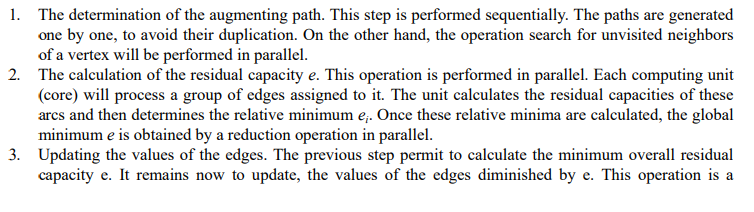
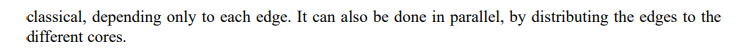

# GPU Implementation

(In Progress..)


In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>

#define MAX_NODES 5

// Kernel to determine the augmenting path
__global__ void bfs_kernel(int* graph, int* visited, int* queue, int* parent, int nodes, int* front, int* rear) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    if (tid == 0) {
        // Source node
        int source = queue[*front];
        visited[source] = 1;
        parent[source] = -1;
        *front = *front + 1;
    }
    __syncthreads();
    while (*front < *rear) {
        int u = queue[*front];
        *front = *front + 1;
        for (int v = 0; v < nodes; v++) {
            if (visited[v] == 0 && graph[u * nodes + v] > 0) {
                parent[v] = u;
                visited[v] = 1;
                int rear_idx = atomicAdd(rear, 1);
                queue[rear_idx] = v;
            }
        }
    }
}

// Kernel to calculate the residual capacity
__global__ void residual_capacity_kernel(int* graph, int* residual_cap, int nodes, int edges_per_thread, int* min_ei) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    for (int i = 0; i < edges_per_thread; i++) {
        int u = (tid * edges_per_thread + i) / nodes;
        int v = (tid * edges_per_thread + i) % nodes;
        if (graph[u * nodes + v] > 0) {
            residual_cap[tid * nodes + v] = graph[u * nodes + v];
            residual_cap[tid * nodes + u] = 0;
        } else {
            residual_cap[tid * nodes + v] = 0;
            residual_cap[tid * nodes + u] = -graph[u * nodes + v];
        }
    }
    __syncthreads();
    // Determine the relative minimum of each thread
    int min_e = INT_MAX;
    for (int i = 0; i < nodes; i++) {
        if (residual_cap[tid * nodes + i] < min_e) {
            min_e = residual_cap[tid * nodes + i];
        }
    }
    min_ei[tid] = min_e;
}

// Kernel to update the values of the edges
__global__ void update_edges_kernel(int* graph, int* residual_cap, int nodes, int edges_per_thread, int min_e) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    for (int i = 0; i < edges_per_thread; i++) {
        int u = (tid * edges_per_thread + i) / nodes;
        int v = (tid * edges_per_thread + i) % nodes;
        if (residual_cap[tid * nodes + v] > 0) {
            atomicSub(&graph[u * nodes + v], min_e);
            atomicAdd(&graph[v * nodes + u], min_e);
        }
    }
}